# African Antelope Classification using FastAI

Interactive notebook with an end-to-end case study of creating a custom image dataset of major African antelope and training a deep convolutional neural network to classify each species.

The basic workflow is as follows:
1. Download images of each antelope and build a dataset.
2. Pre-process and prepare the dataset for learning.
3. Create a deep neural network model for classification.
4. Train the DNN using transfer learning on the data.
5. Validate and evaluate the model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [127]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [136]:
from antelope_classification import *

In [4]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
antelopes = ANTELOPE; print(antelopes)

['kudu', 'eland', 'sable antelope', 'roan antelope', 'waterbuck', 'impala antelope', 'nyala', 'bushbuck', 'tsessebe', 'lichtensteins hartebeest', 'grey duiker', 'steenbok', 'klipspringer']


## Download image data

Download images to data directory, each species is added to its own directory. We also check whether the image file names indicate any potential mislabeling.

In [6]:
download_antelope_images(DATA_PATH)

INFO:root:Directory 'data' is not empty. Skipping image download.


In [138]:
validate_labels(DATA_PATH, ANTELOPE)

Potential mislabeling: data/kudu/39. nyala-kudu-2.jpg
Potential mislabeling: data/kudu/48. nyala-kudu-2.jpg
Potential mislabeling: data/nyala/36. difference-between-kudu-and-nyala-1.jpg


## Build and visualize datasets

With the data downloaded, we can construct an [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch) with appropriate transforms. The image data is normalized with the imagenet statistics.

In [181]:
DATA_PATH = Path('data')
VALID_PCT = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 32
ARCHITECTURE = models.resnet34

In [182]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=get_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

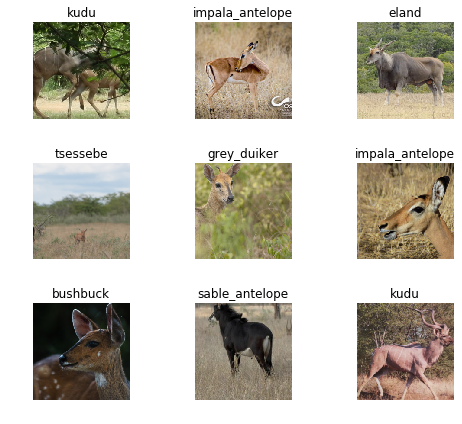

In [94]:
image_data.show_batch(3, figsize=(7,6))

In [140]:
print(image_data.classes)
len(image_data.classes) == image_data.c == len(ANTELOPE)

['bushbuck', 'eland', 'grey_duiker', 'impala_antelope', 'klipspringer', 'kudu', 'lichtensteins_hartebeest', 'nyala', 'roan_antelope', 'sable_antelope', 'steenbok', 'tsessebe', 'waterbuck']


True

## Create Pre-trained Model

We now create a CNN model pre-trained on the Imagenet dataset.

In [128]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate, accuracy])

In [97]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Train Model (top layer)

In the first stage of training, we only train the top (fully-connected) layers of the ResNet. We first find an appropriate learning rate to use.

In [82]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


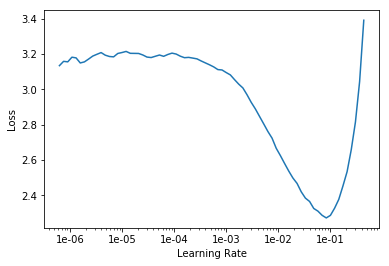

In [83]:
learn.recorder.plot()

In [129]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.893536,0.704844,0.209607,0.790393,00:07
1,1.203250,0.584248,0.183406,0.816594,00:07
2,0.855061,0.499912,0.148472,0.851528,00:07
3,0.611694,0.444256,0.135371,0.864629,00:07


In [99]:
learn.save('stage-1')

### Results and Interpretation

With the model trained we can investigate where the model is struggling and validate its accuracy.

In [175]:
from sklearn.metrics import f1_score

In [100]:
interp = ClassificationInterpretation.from_learner(learn)

In [101]:
losses, idxs = interp.top_losses()

In [102]:
len(image_data.valid_ds) == len(losses)

True

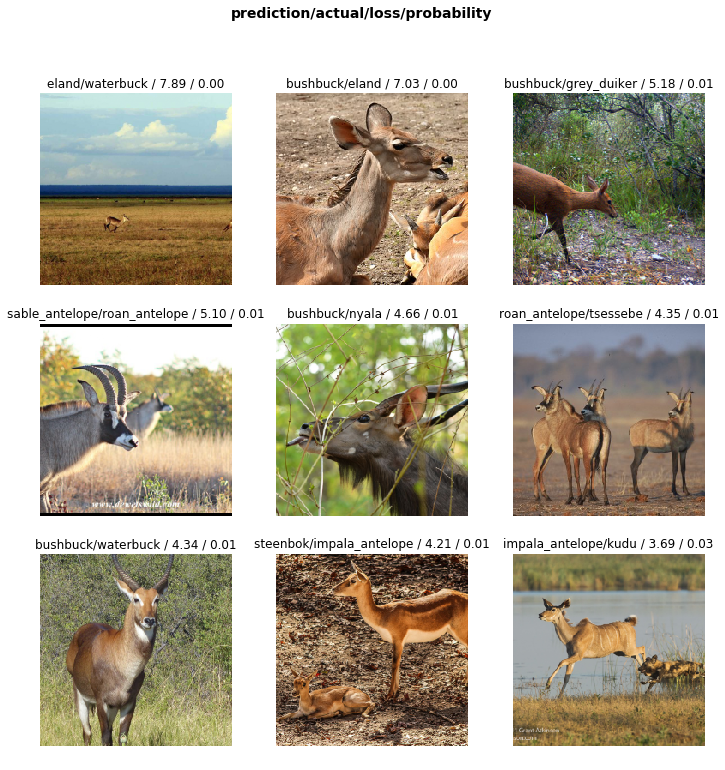

In [108]:
interp.plot_top_losses(9, heatmap=False)

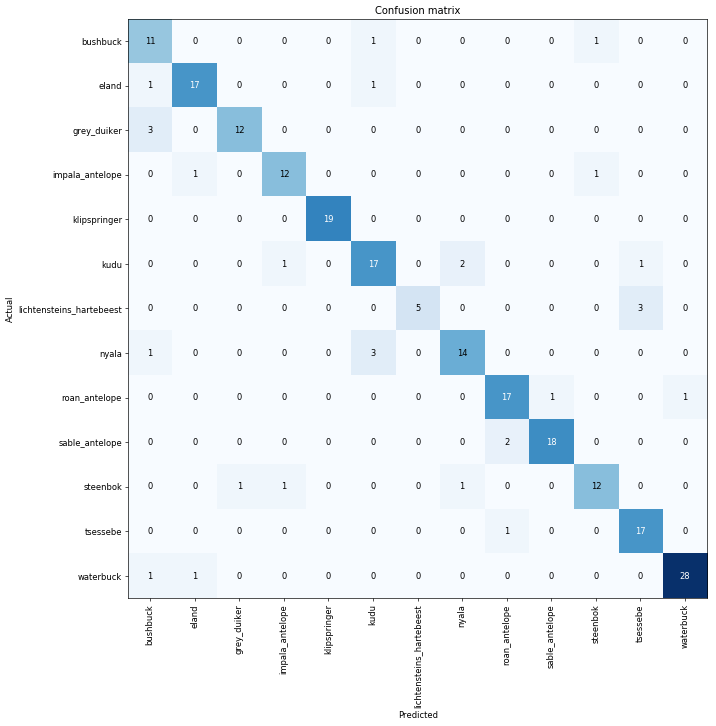

In [106]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [107]:
interp.most_confused(min_val=2)

[('grey_duiker', 'bushbuck', 3),
 ('lichtensteins_hartebeest', 'tsessebe', 3),
 ('nyala', 'kudu', 3),
 ('kudu', 'nyala', 2),
 ('sable_antelope', 'roan_antelope', 2)]

In [176]:
preds, targets = learn.get_preds()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.8820960698689956

## Train Model (all weights)

For the second stage of training we can proceed with unfreezing the other layers of the ResNet, allowing us to train all the layers of the neural network.

In [130]:
learn.unfreeze()

In [131]:
learn.lr_find()

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fbe7f028378>
Traceback (most recent call last):
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fbe7f028378>
Traceback (most recent call last):
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fbe7f028378>
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __de

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fbe7f028378>
Traceback (most recent call last):
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multip

  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/avanwyk/Tools/anaconda/envs/fai-course-env/lib/pytho

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


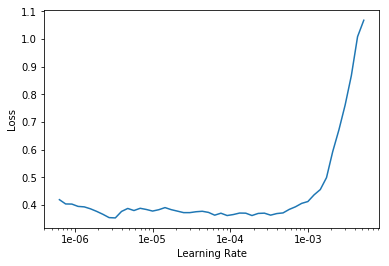

In [132]:
learn.recorder.plot()

In [133]:
learn.fit_one_cycle(4, max_lr=1e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.408866,0.442409,0.126638,0.873362,00:08
1,0.346819,0.438978,0.122271,0.877729,00:09
2,0.352824,0.438304,0.126638,0.873362,00:09
3,0.342371,0.435460,0.117904,0.882096,00:09


In [ ]:
learn.save('stage-2')

### Results and Interpretation

In [134]:
interp = ClassificationInterpretation.from_learner(learn)

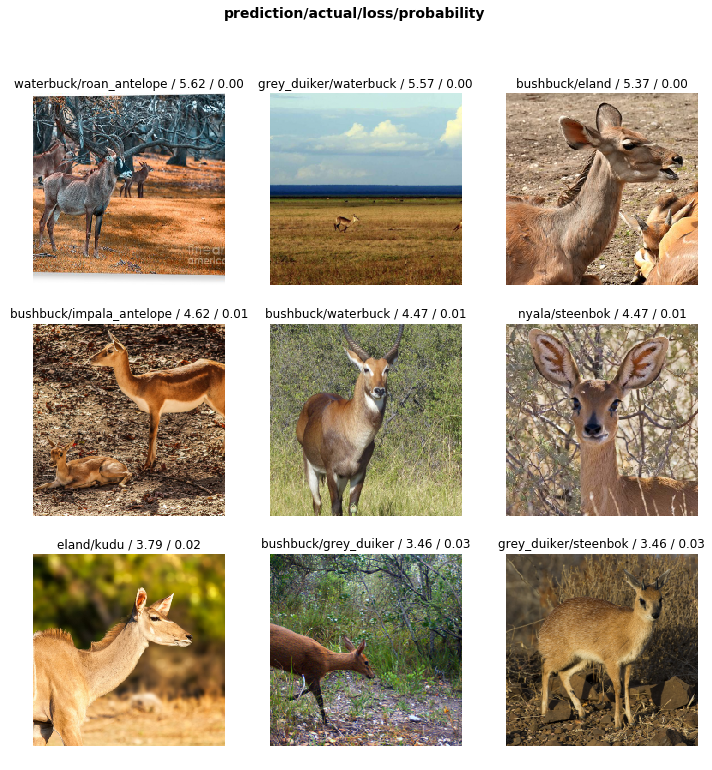

In [135]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=False)

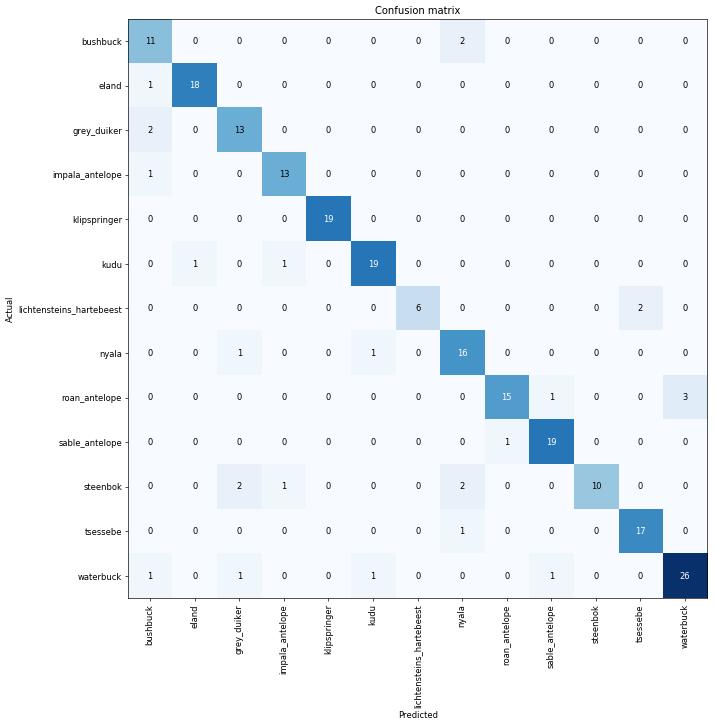

In [179]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [180]:
interp.most_confused(min_val=2)

[('roan_antelope', 'waterbuck', 3),
 ('bushbuck', 'nyala', 2),
 ('grey_duiker', 'bushbuck', 2),
 ('lichtensteins_hartebeest', 'tsessebe', 2),
 ('steenbok', 'grey_duiker', 2),
 ('steenbok', 'nyala', 2)]

In [178]:
preds, targets = learn.get_preds()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.8820960698689956